This project is designed to take in a dataset of 5000 text messages and create a model that can identify key phrases between spam and ham text messages. The program will then label it as a 1 for spam or 0 for ham (non spam text message) and a report will be created on the performance of the model.

The Dataset used is provided by Kaggle 
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset


In [60]:
import os
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve,confusion_matrix,auc
from sklearn.svm import SVC

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset


import matplotlib.pyplot as plt

Calls libary functions and imports them for use later on

In [65]:
# Read SMS message dataset

df = pd.read_csv("dataset/Khilnani_LP_spam_detection_data.csv", encoding='ISO-8859-1')

# df is the call name for the SMS message dataset
# Print the first three indexs of the dataset

df.head(3)

,Unnamed: 0,SMS,label
0,0,"Go until jurong point, crazy.. Available only ...",0
1,1,Ok lar... Joking wif u oni...\n,0
2,2,Free entry in 2 a wkly comp to win FA Cup fina...,1


In [67]:
print(df['label'].value_counts())

label
0    4827
1     747
Name: count, dtype: int64


In [69]:
df_spam = df[df['label'] == 1]  # Spam messages
df_ham = df[df['label'] == 0].sample(n=len(df_spam))  # Undersample ham to match spam count

df_balanced = pd.concat([df_spam, df_ham])

# Shuffle the dataset to mix ham and spam messages
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Split the balanced data into features and labels
X = df_balanced['SMS'].values
y = df_balanced['label'].values

In [70]:
from sklearn.utils import resample

# Upsample the minority class (spam)
df_spam_upsampled = resample(df_spam, replace=True, n_samples=len(df_ham), random_state=42)

# Combine the upsampled spam data with the ham data
df_balanced = pd.concat([df_spam_upsampled, df_ham])

# Shuffle the dataset to mix ham and spam messages
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

# Now split the balanced data into features and labels
X = df_balanced['SMS'].values
y = df_balanced['label'].values

In [71]:
# Start splitting the information and labeling
# Import SuffleSplit function
from sklearn.model_selection import StratifiedShuffleSplit

# Take StratifiedShuffleSplit takes in number of splits, and creates a test size of %30 of the total data set size with a 
splitter = StratifiedShuffleSplit(
    n_splits=1, test_size=0.3, random_state=0
)

# splits the two arrays by each index into a training index and test index based on the splitter parameters 
# X holds a text message string at each index
# Y holds a boolean value of 0 (ham) or 1 (spam)
for train_index, test_index in splitter.split(X, y):
    #stores the values at each indexes in X array into a train and test declared for pre_vectorization
    X_train_pre_tokenizer, X_test_pre_tokenizer = X[train_index], X[test_index]
    #stores the values at each indexes in y array into a train and test
    y_train, y_test = y[train_index], y[test_index]

X_train_pre_tokenizer, X_val_pre_tokenizer, y_train, y_val = train_test_split(
    X_train_pre_tokenizer, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(len(X_train_pre_tokenizer))
print(len(y_train))

836
836


In [72]:
# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/mnt/c/Users/David/Documents/Github/Identifying-SPAM-Using-Transformers/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [73]:
train_encodings = tokenizer(X_train_pre_tokenizer.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val_pre_tokenizer.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test_pre_tokenizer.tolist(), truncation=True, padding=True, max_length=512)

# Convert to tensors
X_train_input_ids = torch.tensor(train_encodings['input_ids'])
X_train_attention_masks = torch.tensor(train_encodings['attention_mask'])
y_train = torch.tensor(y_train)

X_val_input_ids = torch.tensor(val_encodings['input_ids'])
X_val_attention_masks = torch.tensor(val_encodings['attention_mask'])
y_val = torch.tensor(y_val)

X_test_input_ids = torch.tensor(test_encodings['input_ids'])
X_test_attention_masks = torch.tensor(test_encodings['attention_mask'])
y_test = torch.tensor(y_test)

print("Training label distribution:", np.bincount(y_train))
print("Validation label distribution:", np.bincount(y_val))

print(X_train_input_ids.shape)
print(X_train_attention_masks.shape)
print(y_train.shape)

Training label distribution: [418 418]
Validation label distribution: [104 105]
torch.Size([836, 140])
torch.Size([836, 140])
torch.Size([836])


In [74]:
train_data = TensorDataset(X_train_input_ids, X_train_attention_masks, y_train)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_data = TensorDataset(X_val_input_ids, X_val_attention_masks, y_val)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [75]:
test_data = TensorDataset(X_test_input_ids, X_test_attention_masks, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [76]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Loss function
loss_fn = CrossEntropyLoss()

# Training loop
model.train()  # Set model to training mode

epochs = 3
for epoch in range(epochs):
    total_train_loss = 0

    # Training
    for batch in train_loader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]
        
        optimizer.zero_grad()  # Clear previous gradients
        
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    predictions, true_labels = [], []

    for batch in val_loader:
        batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

        with torch.no_grad():  # Don't compute gradients during validation
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, labels=batch_labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(true_labels, predictions)
    
    print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    model.train()  # Set model back to training mode after validation


/mnt/c/Users/David/Documents/Github/Identifying-SPAM-Using-Transformers/.venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Training Loss: 0.19365136179510714
Epoch 1, Validation Loss: 0.1352210062323138, Validation Accuracy: 0.9617224880382775
Epoch 2, Training Loss: 0.04753992403418107
Epoch 2, Validation Loss: 0.03295857534145138, Validation Accuracy: 0.9808612440191388
Epoch 3, Training Loss: 0.019098915445249318
Epoch 3, Validation Loss: 0.01529770194818931, Validation Accuracy: 0.9904306220095693


Part 2. Evaluation

In [77]:
for i in range(10):  # Print first 10 validation samples
    print(f"Predicted: {predictions[i]}, Actual: {true_labels[i]}")

Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


In [78]:
from sklearn.metrics import accuracy_score

model.eval()  # Set model to evaluation mode
predictions, true_labels = [], []

for batch in test_loader:
    batch_input_ids, batch_attention_masks, batch_labels = [x.to(device) for x in batch]

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)

    logits = outputs.logits
    predictions.extend(torch.argmax(logits, axis=-1).cpu().numpy())
    true_labels.extend(batch_labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9732739420935412


In [79]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       225
           1       0.96      0.99      0.97       224

    accuracy                           0.97       449
   macro avg       0.97      0.97      0.97       449
weighted avg       0.97      0.97      0.97       449



In [80]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

# Calculate the AUC score
roc_auc = roc_auc_score(true_labels, predictions)

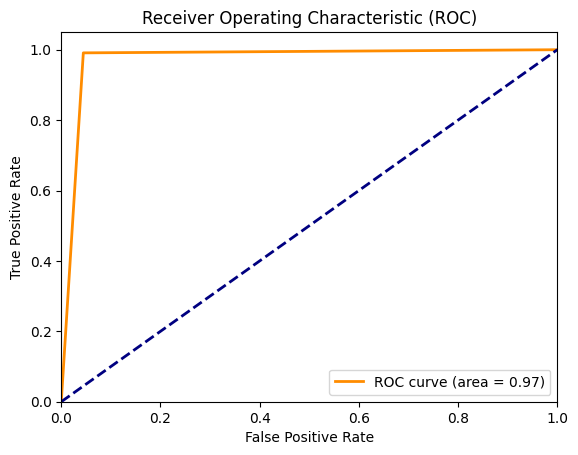

In [81]:
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Pt 3. Implementation

In [82]:
model.to(device)
model.eval()  # Set the model to evaluation mode

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [86]:
def predict_spam_or_ham(text):
    # Tokenize the input text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt", max_length=512).to(device)
    
    # Pass the tokenized input through the model to get logits
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    
    # Apply softmax to get probabilities
    probabilities = torch.softmax(logits, dim=1)
    
    # Get the predicted class
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Get the probability of spam (class 1)
    spam_probability = probabilities[0][1].item()
    
    # Map predicted class to "ham" or "spam"
    if predicted_class == 0:
        return "ham", 1 - spam_probability  # Return ham and the probability
    else:
        return "spam", spam_probability


In [87]:
message = "Congratulations! You have won a free lottery. Click here to claim your prize."
result = predict_spam_or_ham(message)
print(f"Message: {message}\nPrediction: {result}")

Message: Congratulations! You have won a free lottery. Click here to claim your prize.
Prediction: ('spam', 0.9984309077262878)


In [88]:
messages = [
    "Congratulations! You have won a free lottery. Click here to claim your prize.",
    "Hey, are we still meeting for lunch tomorrow?",
    "This is an important notice about your account security.",
]

for message in messages:
    result = predict_spam_or_ham(message)
    print(f"Message: {message}\nPrediction: {result}\n")


Message: Congratulations! You have won a free lottery. Click here to claim your prize.
Prediction: ('spam', 0.9984309077262878)

Message: Hey, are we still meeting for lunch tomorrow?
Prediction: ('ham', 0.995906138792634)

Message: This is an important notice about your account security.
Prediction: ('ham', 0.8374937325716019)

